In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import torch
import random
from diffusers import DPMSolverMultistepScheduler
from models.stablediffusion import StableDiffusionPipeline
from matplotlib import pyplot as plt

In [2]:
def auto_device(obj = torch.device('cpu')):
    if isinstance(obj, torch.device):
        return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if torch.cuda.is_available():
        return obj.to('cuda')

    return obj

def set_seed(seed: int) -> torch.Generator:
    random.seed(seed)
    # np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    gen = torch.Generator(device=auto_device())
    gen.manual_seed(seed)
    return gen

# Model loading...
model_id = "stabilityai/stable-diffusion-2-1"
# model_id = "CompVis/stable-diffusion-v1-4"


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  # Set the GPUs 2 and 3 to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")
net = torch.nn.DataParallel(pipe).to(device)
pipe = net.module
pipe.unet.config.sample_size = 80

print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 8714.39it/s]


Current cuda device: 0
Count of using GPUs: 2


## Figure6. Images generated by Exponential time-steps sampling

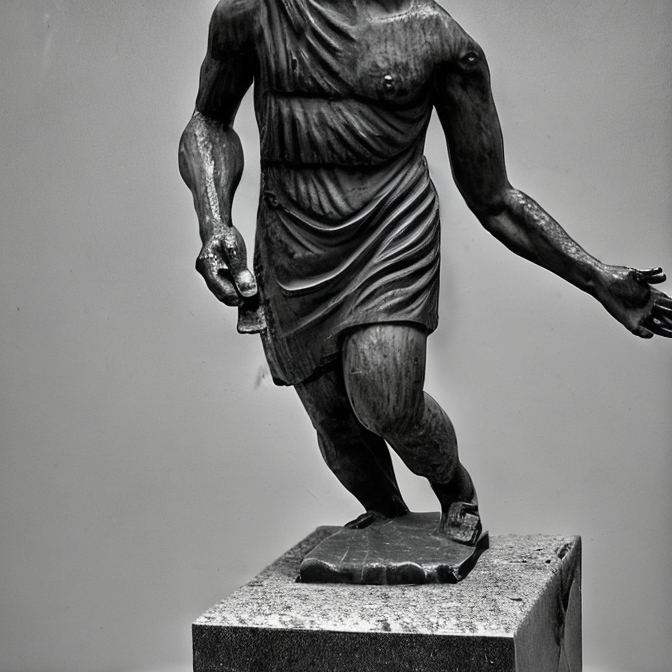

In [ ]:
# Sampling the time-steps with uniform interval
semantic_or_delicate = "uniform"
num_step = 30
gamma = 10
alpha = math.e ** (math.log(1000)/(num_step+gamma))
if semantic_or_delicate == "early":
    time_steps = [1000-int(alpha ** (i+1+gamma))for i in range(num_step)]
    time_steps.insert(0, 999)
    time_steps.pop(-1)
    time_steps = np.array(time_steps)
    time_steps = torch.from_numpy(time_steps).to(device)
    time_steps
elif semantic_or_delicate == "latter":
    time_steps = [int(alpha ** (i+1+gamma))for i in range(num_step)]
    time_steps.sort(reverse=True)
    if time_steps[0] == 1000:
        time_steps[0] = 999
    time_steps = np.array(time_steps)
    time_steps = torch.from_numpy(time_steps).to(device)
    time_steps
else:
    time_steps = None

# Image generation with Latent Diffusion model for 30 inference steps

prompt = "A portrait photo of a Greek statue of a man playing soccer"
visualization_step = 30
seed_num = 1

if semantic_or_delicate == "original":
    output,_,_,  = pipe(
        prompt,
        num_inference_steps=num_step,
        generator=set_seed(seed_num),
        get_images_for_all_inference_steps = True,
        output_type ='pil',
        step_visualization_num = visualization_step,
        visualization_mode = {'mode' : "", 'mask' : "gaussian", 'layer_vis' : False},
        similarity_args = {"sim_func": "ssim", "ssim_mode" : "structure", "get_auc_score" : None},
        time_steps = None,
        )
else:
    output,_,_,  = pipe(
        prompt,
        num_inference_steps=num_step,
        generator=set_seed(seed_num),
        get_images_for_all_inference_steps = True,
        output_type ='pil',
        step_visualization_num = visualization_step,
        visualization_mode = {'mode' : "", 'mask' : "gaussian", 'layer_vis' : False},
        similarity_args = {"sim_func": "ssim", "ssim_mode" : "structure", "get_auc_score" : None},
        time_steps = time_steps,
        )
# img_name = prompt.split("A portrait photo of")[-1]
# output.images[0].save(os.path.join("outputs/sampling_output", f"{img_name}_{semantic_or_delicate}.png"))
torch.cuda.empty_cache()
output.images[0]

### Early stage sampling

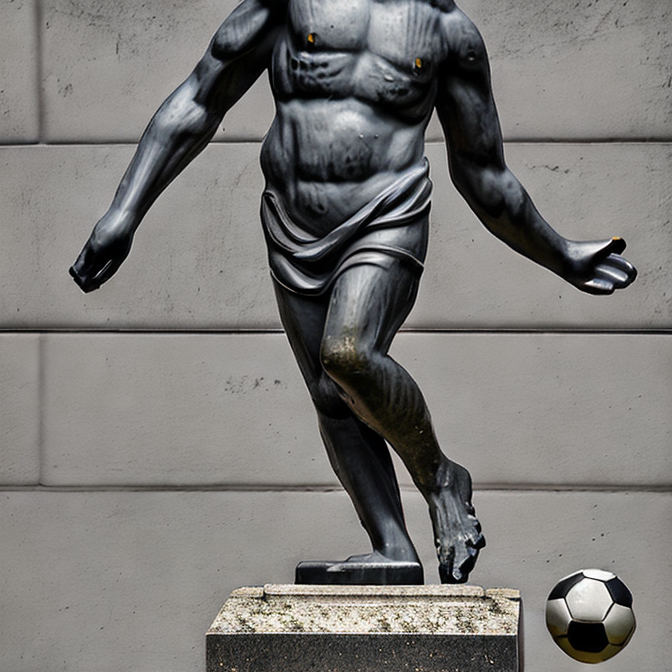

In [66]:
# Setting Exponential time-steps sampling for early stage concentration
semantic_or_delicate = "early"
num_step = 30
gamma = 60
alpha = math.e ** (math.log(1000)/(num_step+gamma))
if semantic_or_delicate == "early":
    time_steps = [1000-int(alpha ** (i+1+gamma))for i in range(num_step)]
    time_steps.insert(0, 999)
    time_steps.pop(-1)
    time_steps = np.array(time_steps)
    time_steps = torch.from_numpy(time_steps).to(device)
    time_steps
elif semantic_or_delicate == "latter":
    time_steps = [int(alpha ** (i+1+gamma))for i in range(num_step)]
    time_steps.sort(reverse=True)
    if time_steps[0] == 1000:
        time_steps[0] = 999
    time_steps = np.array(time_steps)
    time_steps = torch.from_numpy(time_steps).to(device)
    time_steps
else:
    time_steps = None

# Image generation with Latent Diffusion model for 30 inference steps

prompt = "A portrait photo of a Greek statue of a man playing soccer"
visualization_step = 30
seed_num = 1
if semantic_or_delicate == "original":
    output,_,_,  = pipe(
        prompt,
        num_inference_steps=num_step,
        generator=set_seed(seed_num),
        get_images_for_all_inference_steps = True,
        output_type ='pil',
        step_visualization_num = visualization_step,
        visualization_mode = {'mode' : "", 'mask' : "gaussian", 'layer_vis' : False},
        similarity_args = {"sim_func": "ssim", "ssim_mode" : "structure", "get_auc_score" : None},
        time_steps = None,
        )
else:
    output,_,_,  = pipe(
        prompt,
        num_inference_steps=num_step,
        generator=set_seed(seed_num),
        get_images_for_all_inference_steps = True,
        output_type ='pil',
        step_visualization_num = visualization_step,
        visualization_mode = {'mode' : "", 'mask' : "gaussian", 'layer_vis' : False},
        similarity_args = {"sim_func": "ssim", "ssim_mode" : "structure", "get_auc_score" : None},
        time_steps = time_steps,
        )
torch.cuda.empty_cache()
output.images[0]

### Latter stage sampling

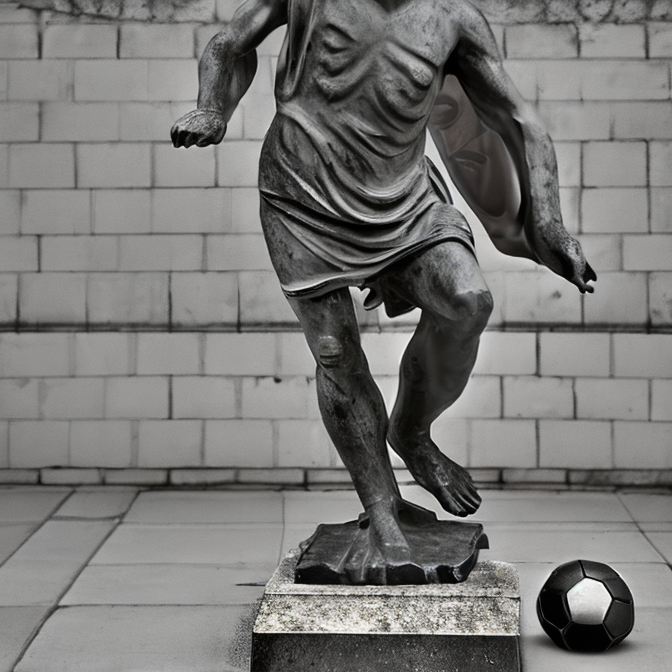

In [68]:
# Setting Exponential time-steps sampling for latter stage concentration
semantic_or_delicate = "latter"
num_step = 30
gamma = 10
alpha = math.e ** (math.log(1000)/(num_step+gamma))
if semantic_or_delicate == "early":
    time_steps = [1000-int(alpha ** (i+1+gamma))for i in range(num_step)]
    time_steps.insert(0, 999)
    time_steps.pop(-1)
    time_steps = np.array(time_steps)
    time_steps = torch.from_numpy(time_steps).to(device)
    time_steps
elif semantic_or_delicate == "latter":
    time_steps = [int(alpha ** (i+1+gamma))for i in range(num_step)]
    time_steps.sort(reverse=True)
    if time_steps[0] == 1000:
        time_steps[0] = 999
    time_steps = np.array(time_steps)
    time_steps = torch.from_numpy(time_steps).to(device)
    time_steps
else:
    time_steps = None

# Image generation with Latent Diffusion model for 30 inference steps

prompt = "A portrait photo of a Greek statue of a man playing soccer"
num_step = 30
visualization_step = 30
seed_num = 1
if semantic_or_delicate == "original":
    output,_,_,  = pipe(
        prompt,
        num_inference_steps=num_step,
        generator=set_seed(seed_num),
        get_images_for_all_inference_steps = True,
        output_type ='pil',
        step_visualization_num = visualization_step,
        visualization_mode = {'mode' : "", 'mask' : "gaussian", 'layer_vis' : False},
        similarity_args = {"sim_func": "ssim", "ssim_mode" : "structure", "get_auc_score" : None},
        time_steps = None,
        )
else:
    output,_,_,  = pipe(
        prompt,
        num_inference_steps=num_step,
        generator=set_seed(seed_num),
        get_images_for_all_inference_steps = True,
        output_type ='pil',
        step_visualization_num = visualization_step,
        visualization_mode = {'mode' : "", 'mask' : "gaussian", 'layer_vis' : False},
        similarity_args = {"sim_func": "ssim", "ssim_mode" : "structure", "get_auc_score" : None},
        time_steps = time_steps,
        )
torch.cuda.empty_cache()
output.images[0]

## Figure10. Image variation using parallel transition

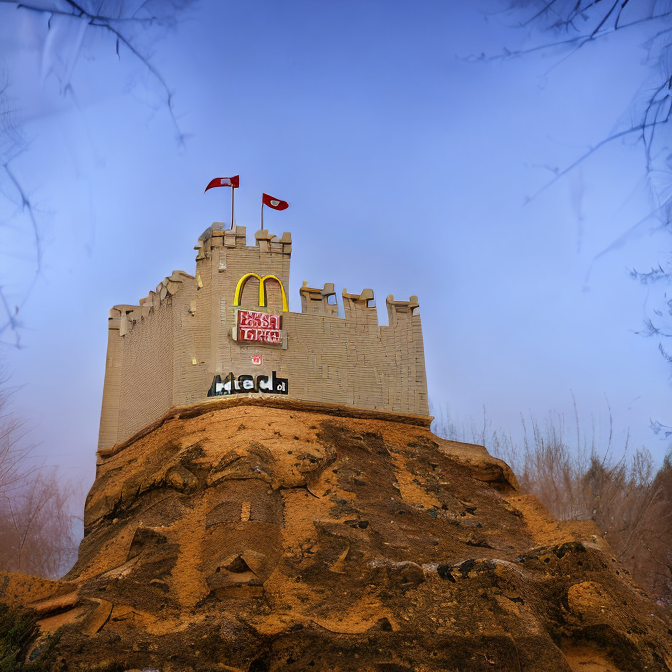

In [40]:
# Controling the sampled time-steps with parallel transition
# semantic_or_delicate = None
semantic_or_delicate = "early"
num_step = 30
gamma = 190
prompt = "A portrait photo of a Mcdonalds castle"
if semantic_or_delicate is not None:
    alpha = math.e ** (math.log(1000)/(num_step+gamma))
    if semantic_or_delicate == "early":
        time_steps = [1000-int(alpha ** (i+1+gamma))for i in range(num_step)]
        time_steps.insert(0, 999)
        time_steps.pop(-1)
        time_steps = np.array(time_steps)
        time_steps = torch.from_numpy(time_steps).to(device)
        time_steps
    elif semantic_or_delicate == "latter":
        time_steps = [int(alpha ** (i+1+gamma))for i in range(num_step)]
        time_steps.sort(reverse=True)
        if time_steps[0] == 1000:
            time_steps[0] = 999
        time_steps = np.array(time_steps)
        time_steps = torch.from_numpy(time_steps).to(device)
        time_steps

    visualization_step = 30
    seed_num = 1
    output,_,_,  = pipe(
        prompt,
        num_inference_steps=num_step,
        generator=set_seed(seed_num),
        get_images_for_all_inference_steps = True,
        output_type ='pil',
        step_visualization_num = visualization_step,
        visualization_mode = {'mode' : "", 'mask' : "gaussian", 'layer_vis' : False},
        similarity_args = {"sim_func": "ssim", "ssim_mode" : "structure", "get_auc_score" : None},
        time_steps = time_steps,
        )
else:
    gamma = "org"
    time_steps = None
    visualization_step = 30
    seed_num = 1
    output,_,_,  = pipe(
        prompt,
        num_inference_steps=num_step,
        generator=set_seed(seed_num),
        get_images_for_all_inference_steps = True,
        output_type ='pil',
        step_visualization_num = visualization_step,
        visualization_mode = {'mode' : "", 'mask' : "gaussian", 'layer_vis' : False},
        similarity_args = {"sim_func": "ssim", "ssim_mode" : "structure", "get_auc_score" : None},
        time_steps = time_steps,
        )
# img_name = prompt.split("A portrait photo of")[-1]
# dir_path = os.path.join("outputs/figure4",img_name)
# if not os.path.isdir(dir_path):
#     os.mkdir(dir_path)
# output.images[0].save(os.path.join(dir_path, f"gamma_{gamma}.png"))
    
torch.cuda.empty_cache()
output.images[0]

## Figure 7. Visualization of the model decision during denoising process.

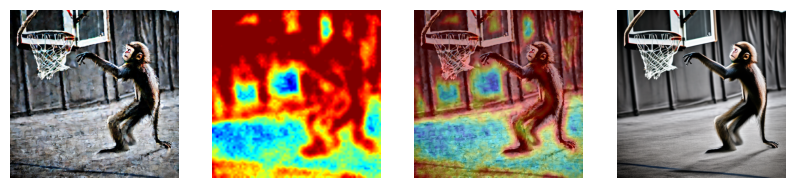

In [9]:
# inference_steps = 5
# visualization_step = 5
num_masks = 200
seed_num = 1
prompt = "A portrait photo of a monkey playing basketball"
for inference_step in range(2,10):
    all_images, rise, auc_score, output = pipe(
        prompt,
        num_inference_steps=inference_step,
        generator=set_seed(seed_num),
        get_images_for_all_inference_steps = True,
        output_type =None,
        step_visualization_num = inference_step,
        visualization_mode = {'mode' : "rise", 'mask' : "gaussian", 'layer_vis' : False},
        rise_num_steps = num_masks,
        similarity_args = {"sim_func": "ssim", "ssim_mode" : "structure", "get_auc_score" : None},
        time_steps = None,
        )
    save = True
    img_name = prompt.split("A portrait photo of")[-1]
    save_pth = os.path.join("./outputs/figure5",img_name )
    if not os.path.exists(save_pth):
        os.mkdir(save_pth)

    img_size = all_images[0].shape[1]

    saliency_map = F.relu(rise).unsqueeze(0).unsqueeze(0)
    saliency = saliency_map.clone()
    # Upsampling
    saliency_map = F.interpolate(saliency_map, size=(img_size, img_size), mode='bilinear', align_corners=False)

    saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
    # normalization
    saliency_map = (saliency_map - saliency_map_min) / (saliency_map_max - saliency_map_min)

    mask = saliency_map.cpu().data
    mask = (mask - mask.min()).div(mask.max() - mask.min()).data
    heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze().float()), cv2.COLORMAP_JET)  # [H, W, 3]
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    org_img = torch.from_numpy(all_images[-1][0]).permute(2,0,1)
    mask_sqz = mask.squeeze(0)
    original_cam = 1 * (1 - mask_sqz ** 0.8) * org_img + (mask_sqz ** 0.8) * heatmap
    original_gradcam = original_cam.cpu().detach().squeeze(0)

    prev_noise = torch.from_numpy(all_images[inference_step-1][0]).permute(2,0,1)
    post_noise = torch.from_numpy(all_images[inference_step][0]).permute(2,0,1)

    # Visualization
    plt.figure('Diffusion RISE', figsize=(10,4))

    plt.subplot(1,4,1)
    plt.imshow(prev_noise.permute(1, 2, 0))
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(heatmap.permute(1, 2, 0))
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(prev_noise.permute(1, 2, 0))
    plt.imshow(heatmap.permute(1, 2, 0), alpha=0.4, cmap='viridis')
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(post_noise.permute(1, 2, 0))
    plt.axis("off")
    if save:
        plt.savefig(os.path.join(save_pth, f"{inference_step}step.png"))
    # plt.show()
    torch.cuda.empty_cache()

## Figure 7. Visualization of the model prediction of at each denoising process.

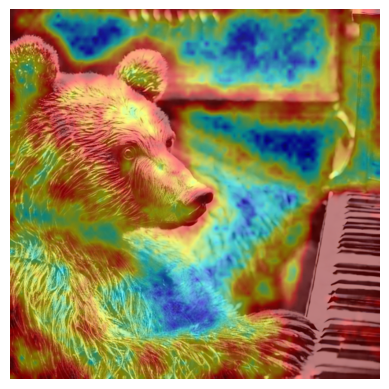

In [11]:
# inference_steps = 5
# visualization_step = 5
num_masks = 200
seed_num = 1
prompt = "A portrait photo of a bear playing piano"
for visualize_step in range(1,21):
    all_images, rise, auc_score, output = pipe(
        prompt,
        num_inference_steps=20,
        generator=set_seed(seed_num),
        get_images_for_all_inference_steps = True,
        output_type =None,
        step_visualization_num = visualize_step,
        visualization_mode = {'mode' : "rise", 'mask' : "gaussian", 'layer_vis' : False},
        rise_num_steps = num_masks,
        similarity_args = {"sim_func": "ssim", "ssim_mode" : "structure", "get_auc_score" : None},
        time_steps = None,
        )
    save = True
    img_name = prompt.split("A portrait photo of")[-1]
    save_pth = os.path.join("./outputs/figure6",img_name)
    if not os.path.exists(save_pth):
        os.mkdir(save_pth)

    img_size = all_images[0].shape[1]

    saliency_map = F.relu(rise).unsqueeze(0).unsqueeze(0)
    saliency = saliency_map.clone()
    # Upsampling
    saliency_map = F.interpolate(saliency_map, size=(img_size, img_size), mode='bilinear', align_corners=False)

    saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
    # normalization
    saliency_map = (saliency_map - saliency_map_min) / (saliency_map_max - saliency_map_min)

    mask = saliency_map.cpu().data
    mask = (mask - mask.min()).div(mask.max() - mask.min()).data
    heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze().float()), cv2.COLORMAP_JET)  # [H, W, 3]
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    org_img = torch.from_numpy(all_images[-1][0]).permute(2,0,1)
    mask_sqz = mask.squeeze(0)
    original_cam = 1 * (1 - mask_sqz ** 0.8) * org_img + (mask_sqz ** 0.8) * heatmap
    original_gradcam = original_cam.cpu().detach().squeeze(0)

    prev_noise = torch.from_numpy(all_images[visualize_step-1][0]).permute(2,0,1)
    post_noise = torch.from_numpy(all_images[visualize_step][0]).permute(2,0,1)

    # Visualization
    plt.imshow(prev_noise.permute(1, 2, 0))
    plt.imshow(heatmap.permute(1, 2, 0), alpha=0.5, cmap='viridis')
    plt.axis("off")
    if save:
        plt.savefig(os.path.join(save_pth, f"{visualize_step}step.png"))
    # plt.show()
    torch.cuda.empty_cache()

## Ablation studies

### 1) FID similarity function

AUC score: 0.509968687951118


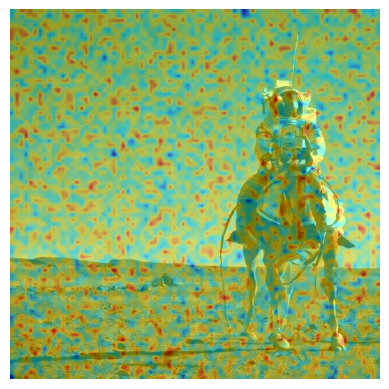

In [3]:
inference_steps = 20
visualization_step = 20 
num_masks = 200
seed_num = 1
save = True

prompt = "A portrait photo of an astronaut riding a horse on mars"
img_name = prompt.split("A portrait photo of")[-1]
save_pth = os.path.join(f"./outputs/ablation/fid",img_name)
if not os.path.exists(save_pth):
    os.mkdir(save_pth)


all_images, rise, auc_score, output = pipe(
    prompt,
    num_inference_steps=inference_steps,
    generator=set_seed(seed_num),
    get_images_for_all_inference_steps = True,
    output_type =None,
    step_visualization_num = visualization_step,
    visualization_mode = {'mode' : "rise", 'mask' : "gaussian", 'layer_vis' : False},
    rise_num_steps = num_masks,
    similarity_args = {"sim_func": "fid", "ssim_mode" : "structure", "get_auc_score" : {"mode": "ins", "verbose": 2, "dir" : save_pth}},
    time_steps = None,
    )


img_size = all_images[0].shape[1]

saliency_map = F.relu(rise).unsqueeze(0).unsqueeze(0)
saliency = saliency_map.clone()
# Upsampling
saliency_map = F.interpolate(saliency_map, size=(img_size, img_size), mode='bilinear', align_corners=False)

saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
# normalization
saliency_map = (saliency_map - saliency_map_min) / (saliency_map_max - saliency_map_min)

mask = saliency_map.cpu().data
mask = (mask - mask.min()).div(mask.max() - mask.min()).data
heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze().float()), cv2.COLORMAP_JET)  # [H, W, 3]
heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

org_img = torch.from_numpy(all_images[-1][0]).permute(2,0,1)
mask_sqz = mask.squeeze(0)
original_cam = 1 * (1 - mask_sqz ** 0.8) * org_img + (mask_sqz ** 0.8) * heatmap
original_gradcam = original_cam.cpu().detach().squeeze(0)

prev_noise = torch.from_numpy(all_images[visualization_step-1][0]).permute(2,0,1)
post_noise = torch.from_numpy(all_images[visualization_step][0]).permute(2,0,1)

# Visualization
plt.imshow(prev_noise.permute(1, 2, 0))
plt.imshow(heatmap.permute(1, 2, 0), alpha=0.5, cmap='viridis')
plt.axis("off")
if save:
    plt.savefig(os.path.join(save_pth, f"{visualization_step}step.png"))
# plt.show()
torch.cuda.empty_cache()
print("AUC score: {}".format(auc_score))

### 2) Cosine similarity function

AUC score: 0.2833936566616489


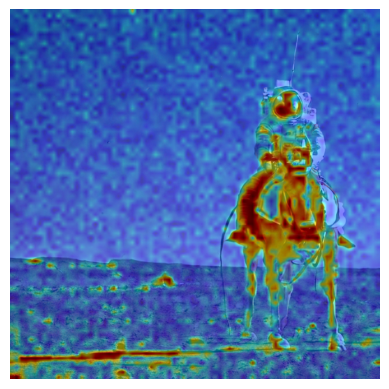

In [4]:
inference_steps = 20
visualization_step = 20 
num_masks = 200
seed_num = 1
prompt = "A portrait photo of an astronaut riding a horse on mars"

save = True
img_name = prompt.split("A portrait photo of")[-1]
save_pth = os.path.join(f"./outputs/ablation/cos",img_name)
if not os.path.exists(save_pth):
    os.mkdir(save_pth)

all_images, rise, auc_score, output = pipe(
    prompt,
    num_inference_steps=inference_steps,
    generator=set_seed(seed_num),
    get_images_for_all_inference_steps = True,
    output_type =None,
    step_visualization_num = visualization_step,
    visualization_mode = {'mode' : "rise", 'mask' : "gaussian", 'layer_vis' : False},
    rise_num_steps = num_masks,
    similarity_args = {"sim_func": "cos", "ssim_mode" : "structure", "get_auc_score" : {"mode": "ins", "verbose": 2, "dir" : save_pth}},
    time_steps = None,
    )

img_size = all_images[0].shape[1]

saliency_map = F.relu(rise).unsqueeze(0).unsqueeze(0)
saliency = saliency_map.clone()
# Upsampling
saliency_map = F.interpolate(saliency_map, size=(img_size, img_size), mode='bilinear', align_corners=False)

saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
# normalization
saliency_map = (saliency_map - saliency_map_min) / (saliency_map_max - saliency_map_min)

mask = saliency_map.cpu().data
mask = (mask - mask.min()).div(mask.max() - mask.min()).data
heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze().float()), cv2.COLORMAP_JET)  # [H, W, 3]
heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

org_img = torch.from_numpy(all_images[-1][0]).permute(2,0,1)
mask_sqz = mask.squeeze(0)
original_cam = 1 * (1 - mask_sqz ** 0.8) * org_img + (mask_sqz ** 0.8) * heatmap
original_gradcam = original_cam.cpu().detach().squeeze(0)

prev_noise = torch.from_numpy(all_images[visualization_step-1][0]).permute(2,0,1)
post_noise = torch.from_numpy(all_images[visualization_step][0]).permute(2,0,1)

# Visualization
plt.imshow(prev_noise.permute(1, 2, 0))
plt.imshow(heatmap.permute(1, 2, 0), alpha=0.5, cmap='viridis')
plt.axis("off")
if save:
    plt.savefig(os.path.join(save_pth, f"{visualization_step}step.png"))
# plt.show()
torch.cuda.empty_cache()
print("AUC score: {}".format(auc_score))

### 3) Luminance similarity function

AUC score: 0.3372113478338368


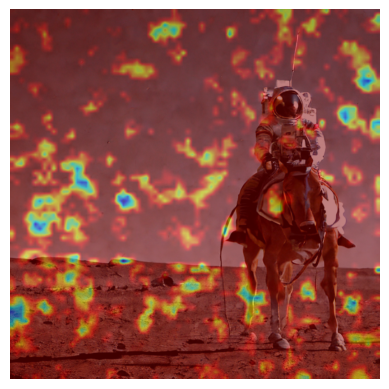

In [5]:
inference_steps = 20
visualization_step = 20 
num_masks = 200
seed_num = 1
prompt = "A portrait photo of an astronaut riding a horse on mars"
save = True

img_name = prompt.split("A portrait photo of")[-1]
save_pth = os.path.join(f"./outputs/ablation/luminance",img_name)
if not os.path.exists(save_pth):
    os.mkdir(save_pth)
    
all_images, rise, auc_score, output = pipe(
    prompt,
    num_inference_steps=inference_steps,
    generator=set_seed(seed_num),
    get_images_for_all_inference_steps = True,
    output_type =None,
    step_visualization_num = visualization_step,
    visualization_mode = {'mode' : "rise", 'mask' : "gaussian", 'layer_vis' : False},
    rise_num_steps = num_masks,
    similarity_args = {"sim_func": "ssim", "ssim_mode" : "luminance", "get_auc_score" : {"mode": "ins", "verbose": 2, "dir" : save_pth}},
    time_steps = None,
    )


img_size = all_images[0].shape[1]

saliency_map = F.relu(rise).unsqueeze(0).unsqueeze(0)
saliency = saliency_map.clone()
# Upsampling
saliency_map = F.interpolate(saliency_map, size=(img_size, img_size), mode='bilinear', align_corners=False)

saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
# normalization
saliency_map = (saliency_map - saliency_map_min) / (saliency_map_max - saliency_map_min)

mask = saliency_map.cpu().data
mask = (mask - mask.min()).div(mask.max() - mask.min()).data
heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze().float()), cv2.COLORMAP_JET)  # [H, W, 3]
heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

org_img = torch.from_numpy(all_images[-1][0]).permute(2,0,1)
mask_sqz = mask.squeeze(0)
original_cam = 1 * (1 - mask_sqz ** 0.8) * org_img + (mask_sqz ** 0.8) * heatmap
original_gradcam = original_cam.cpu().detach().squeeze(0)

prev_noise = torch.from_numpy(all_images[visualization_step-1][0]).permute(2,0,1)
post_noise = torch.from_numpy(all_images[visualization_step][0]).permute(2,0,1)

# Visualization
plt.imshow(prev_noise.permute(1, 2, 0))
plt.imshow(heatmap.permute(1, 2, 0), alpha=0.5, cmap='viridis')
plt.axis("off")
if save:
    plt.savefig(os.path.join(save_pth, f"{visualization_step}step.png"))
# plt.show()
torch.cuda.empty_cache()
print("AUC score: {}".format(auc_score))

### 4) Contrast similarity function

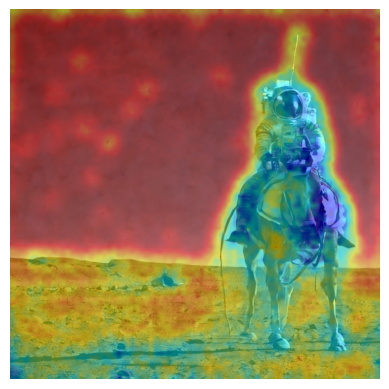

In [6]:
inference_steps = 20
visualization_step = 20 
num_masks = 200
seed_num = 1
prompt = "A portrait photo of an astronaut riding a horse on mars"

save = True
img_name = prompt.split("A portrait photo of")[-1]
save_pth = os.path.join(f"./outputs/ablation/contrast",img_name)
if not os.path.exists(save_pth):
    os.mkdir(save_pth)

all_images, rise, auc_score, output = pipe(
    prompt,
    num_inference_steps=inference_steps,
    generator=set_seed(seed_num),
    get_images_for_all_inference_steps = True,
    output_type =None,
    step_visualization_num = visualization_step,
    visualization_mode = {'mode' : "rise", 'mask' : "gaussian", 'layer_vis' : False},
    rise_num_steps = num_masks,
    similarity_args = {"sim_func": "ssim", "ssim_mode" : "contrast", "get_auc_score" : {"mode": "ins", "verbose": 2, "dir" : save_pth}},
    time_steps = None,
    )

img_size = all_images[0].shape[1]

saliency_map = F.relu(rise).unsqueeze(0).unsqueeze(0)
saliency = saliency_map.clone()
# Upsampling
saliency_map = F.interpolate(saliency_map, size=(img_size, img_size), mode='bilinear', align_corners=False)

saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
# normalization
saliency_map = (saliency_map - saliency_map_min) / (saliency_map_max - saliency_map_min)

mask = saliency_map.cpu().data
mask = (mask - mask.min()).div(mask.max() - mask.min()).data
heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze().float()), cv2.COLORMAP_JET)  # [H, W, 3]
heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

org_img = torch.from_numpy(all_images[-1][0]).permute(2,0,1)
mask_sqz = mask.squeeze(0)
original_cam = 1 * (1 - mask_sqz ** 0.8) * org_img + (mask_sqz ** 0.8) * heatmap
original_gradcam = original_cam.cpu().detach().squeeze(0)

prev_noise = torch.from_numpy(all_images[visualization_step-1][0]).permute(2,0,1)
post_noise = torch.from_numpy(all_images[visualization_step][0]).permute(2,0,1)

# Visualization
plt.imshow(prev_noise.permute(1, 2, 0))
plt.imshow(heatmap.permute(1, 2, 0), alpha=0.5, cmap='viridis')
plt.axis("off")
if save:
    plt.savefig(os.path.join(save_pth, f"{visualization_step}step.png"))
# plt.show()
torch.cuda.empty_cache()

### Structure

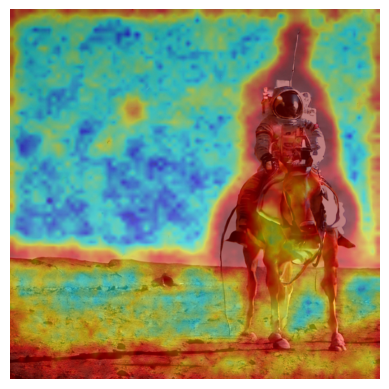

In [7]:
inference_steps = 20
visualization_step = 20 
num_masks = 200
seed_num = 1
prompt = "A portrait photo of an astronaut riding a horse on mars"

save = True
img_name = prompt.split("A portrait photo of")[-1]
save_pth = os.path.join(f"./outputs/ablation/structure",img_name)
if not os.path.exists(save_pth):
    os.mkdir(save_pth)

all_images, rise, auc_score, output = pipe(
    prompt,
    num_inference_steps=inference_steps,
    generator=set_seed(seed_num),
    get_images_for_all_inference_steps = True,
    output_type =None,
    step_visualization_num = visualization_step,
    visualization_mode = {'mode' : "rise", 'mask' : "gaussian", 'layer_vis' : False},
    rise_num_steps = num_masks,
    similarity_args = {"sim_func": "ssim", "ssim_mode" : "structure", "get_auc_score" : {"mode": "ins", "verbose": 2, "dir" : save_pth}},
    time_steps = None,
    )


img_size = all_images[0].shape[1]

saliency_map = F.relu(rise).unsqueeze(0).unsqueeze(0)
saliency = saliency_map.clone()
# Upsampling
saliency_map = F.interpolate(saliency_map, size=(img_size, img_size), mode='bilinear', align_corners=False)

saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
# normalization
saliency_map = (saliency_map - saliency_map_min) / (saliency_map_max - saliency_map_min)

mask = saliency_map.cpu().data
mask = (mask - mask.min()).div(mask.max() - mask.min()).data
heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze().float()), cv2.COLORMAP_JET)  # [H, W, 3]
heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

org_img = torch.from_numpy(all_images[-1][0]).permute(2,0,1)
mask_sqz = mask.squeeze(0)
original_cam = 1 * (1 - mask_sqz ** 0.8) * org_img + (mask_sqz ** 0.8) * heatmap
original_gradcam = original_cam.cpu().detach().squeeze(0)

prev_noise = torch.from_numpy(all_images[visualization_step-1][0]).permute(2,0,1)
post_noise = torch.from_numpy(all_images[visualization_step][0]).permute(2,0,1)

# Visualization
plt.imshow(prev_noise.permute(1, 2, 0))
plt.imshow(heatmap.permute(1, 2, 0), alpha=0.5, cmap='viridis')
plt.axis("off")
if save:
    plt.savefig(os.path.join(save_pth, f"{visualization_step}step.png"))
# plt.show()
torch.cuda.empty_cache()

## Layer Visualization

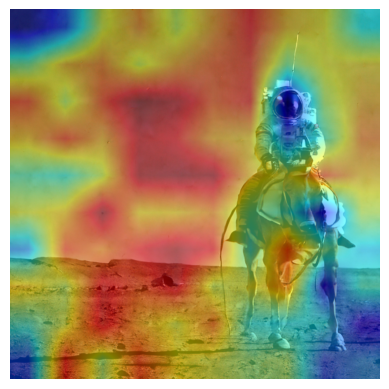

In [3]:
inference_steps = 20
visualization_step = 20 
num_masks = 1000
seed_num = 1
prompt = "A portrait photo of an astronaut riding a horse on mars"

save = True
img_name = prompt.split("A portrait photo of")[-1]
save_pth = os.path.join(f"./outputs/layer_vis",img_name)
if not os.path.exists(save_pth):
    os.mkdir(save_pth)

all_images, rise, auc_score, output = pipe(
    prompt,
    num_inference_steps=inference_steps,
    generator=set_seed(seed_num),
    get_images_for_all_inference_steps = True,
    output_type =None,
    step_visualization_num = visualization_step,
    visualization_mode = {'mode' : "rise", 'mask' : "gaussian", 'layer_vis' : True},
    rise_num_steps = num_masks,
    similarity_args = {"sim_func": "ssim", "ssim_mode" : "structure", "get_auc_score" : None},
    time_steps = None,
    )


img_size = all_images[0].shape[1]

saliency_map = F.relu(rise).unsqueeze(0).unsqueeze(0)
saliency = saliency_map.clone()
# Upsampling
saliency_map = F.interpolate(saliency_map, size=(img_size, img_size), mode='bilinear', align_corners=False)

saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
# normalization
saliency_map = (saliency_map - saliency_map_min) / (saliency_map_max - saliency_map_min)

mask = saliency_map.cpu().data
mask = (mask - mask.min()).div(mask.max() - mask.min()).data
heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze().float()), cv2.COLORMAP_JET)  # [H, W, 3]
heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

org_img = torch.from_numpy(all_images[-1][0]).permute(2,0,1)
mask_sqz = mask.squeeze(0)
original_cam = 1 * (1 - mask_sqz ** 0.8) * org_img + (mask_sqz ** 0.8) * heatmap
original_gradcam = original_cam.cpu().detach().squeeze(0)

prev_noise = torch.from_numpy(all_images[visualization_step-1][0]).permute(2,0,1)
post_noise = torch.from_numpy(all_images[visualization_step][0]).permute(2,0,1)

# Visualization
plt.imshow(prev_noise.permute(1, 2, 0))
plt.imshow(heatmap.permute(1, 2, 0), alpha=0.5, cmap='viridis')
plt.axis("off")
if save:
    plt.savefig(os.path.join(save_pth, f"Mid_L0.png"))
# plt.show()
torch.cuda.empty_cache()